## Sprintの目的
>コンピュータビジョンの代表的タスクであるセグメンテーションを学ぶ

## セグメンテーション

>KaggleのTGS Salt Identification Challengeのデータセットを使用し、セグメンテーションを行います。
>
>TGS Salt Identification Challenge | Kaggle
>
>セグメンテーション手法としてU-Net[1]を使います。
>
>[1]O.Ronneberger, P.Fischer, T.Brox. U-Net: Convolutional Networks for Biomedical Image Segmentation. Medical Image Computing and Computer-Assisted Intervention (MICCAI), Springer, LNCS, Vol.9351: 234–241, 2015
>
>https://arxiv.org/pdf/1505.04597.pdf

## 【問題1】学習・推定
>以下のKeras実装を使用して学習・推定を行ってください。
>
>zhixuhao/unet: unet for image segmentation
>
>《GPU環境での学習》
>
>大規模なデータセット、大きなモデルになるため、GPUを使用する必要があります。
>
>《新たなデータセットの適用》
>
>公開されている実装で用意されたものとは異なるデータセットを入力するための準備が必要です。

In [24]:
!pip install tensorflow==1.5.0#1.5.0

ERROR: Could not find a version that satisfies the requirement tensorflow==1.5.0#1.5.0
ERROR: No matching distribution found for tensorflow==1.5.0#1.5.0


In [2]:
!pip install keras==2.2

In [3]:
!pip install --upgrade pip

In [4]:
!pip install scikit-image

In [5]:
!pip install --upgrade scikit-image

In [6]:
!pip install h5py==2.6.0

In [7]:
from data import *

Using TensorFlow backend.
/Users/ishiitomoaki/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:493: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/ishiitomoaki/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:494: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/ishiitomoaki/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:495: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dt

# data augmentation 

In deep learning tasks, a lot of data is need to train DNN model, when the dataset is not big enough, data augmentation should be applied.

keras.preprocessing.image.ImageDataGenerator is a data generator, which can feed the DNN with data like : (data,label), it can also do data augmentation at the same time.

It is very convenient for us to use keras.preprocessing.image.ImageDataGenerator to do data augmentation by implement image rotation, shift, rescale and so on... see [keras documentation](https://keras.io/preprocessing/image/) for detail.

For image segmentation tasks, the image and mask must be transformed **together!!**

## define your data generator

If you want to visualize your data augmentation result, set save_to_dir = your path

In [8]:
#if you don't want to do data augmentation, set data_gen_args as an empty dict.
#data_gen_args = dict()

data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')
myGenerator = trainGenerator(20,'data/membrane/train','image','label',data_gen_args,save_to_dir = "data/membrane/train/aug")

## visualize your data augmentation result

In [9]:
#you will see 60 transformed images and their masks in data/membrane/train/aug
num_batch = 3
for i,batch in enumerate(myGenerator):
    if(i >= num_batch):
        break

Found 24 images belonging to 1 classes.
Found 24 images belonging to 1 classes.


## create .npy data

If your computer has enough memory, you can create npy files containing all your images and masks, and feed your DNN with them.

In [10]:
image_arr,mask_arr = geneTrainNpy("data/membrane/train/aug/","data/membrane/train/aug/")
#np.save("data/image_arr.npy",image_arr)
#np.save("data/mask_arr.npy",mask_arr)

## Train your Unet with membrane data
membrane data is in folder membrane/, it is a binary classification task.

The input shape of image and mask are the same :(batch_size,rows,cols,channel = 1)


### Train with data generator

In [11]:
from model import *

In [12]:
data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')
myGene = trainGenerator(2,'data/membrane/train','image','label',data_gen_args,save_to_dir = None)
model = unet()
model_checkpoint = ModelCheckpoint('unet_membrane.hdf5', monitor='loss',verbose=1, save_best_only=True)
model.fit_generator(myGene,steps_per_epoch=5,epochs=5,callbacks=[model_checkpoint])

Epoch 1/5
Found 24 images belonging to 1 classes.
Found 24 images belonging to 1 classes.
5/5 [==============================] - 145s 29s/step - loss: 0.7901 - acc: 0.6910

Epoch 00001: loss improved from inf to 0.79014, saving model to unet_membrane.hdf5
Epoch 2/5
5/5 [==============================] - 143s 29s/step - loss: 0.6610 - acc: 0.8739

Epoch 00002: loss improved from 0.79014 to 0.66101, saving model to unet_membrane.hdf5
Epoch 3/5
5/5 [==============================] - 124s 25s/step - loss: 0.4320 - acc: 0.8880

Epoch 00003: loss improved from 0.66101 to 0.43199, saving model to unet_membrane.hdf5
Epoch 4/5
5/5 [==============================] - 120s 24s/step - loss: 0.5009 - acc: 0.8151

Epoch 00004: loss did not improve from 0.43199
Epoch 5/5
5/5 [==============================] - 132s 26s/step - loss: 0.5493 - acc: 0.7602

Epoch 00005: loss did not improve from 0.43199


### Train with npy file

In [13]:
#imgs_train,imgs_mask_train = geneTrainNpy("data/membrane/train/aug/","data/membrane/train/aug/")
#model.fit(imgs_train, imgs_mask_train, batch_size=2, nb_epoch=10, verbose=1,validation_split=0.2, shuffle=True, callbacks=[model_checkpoint])

### test your model and save predicted results


In [14]:
testGene = testGenerator("data/membrane/test")
model = unet()
model.load_weights("unet_membrane.hdf5")#, by_name=False
results = model.predict_generator(testGene,30,verbose=1)
saveResult("data/membrane/test",results)

30/30 [==============================] - 114s 4s/step


/Users/ishiitomoaki/JupyterNotebook/DiveIntoCode_課題/Sprint19_セグメンテーション 1/unet-master/data.py:124: UserWarning: data/membrane/test/0_predict.png is a low contrast image
  io.imsave(os.path.join(save_path,"%d_predict.png"%i),img)
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/ishiitomoaki/JupyterNotebook/DiveIntoCode_課題/Sprint19_セグメンテーション 1/unet-master/data.py:124: UserWarning: data/membrane/test/1_predict.png is a low contrast image
  io.imsave(os.path.join(save_path,"%d_predict.png"%i),img)
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/ishiitomoaki/JupyterNotebook/DiveIntoCode_課題/Sprint19_セグメンテーション 1/unet-master/data.py:124: UserWarning: data/membrane/test/2_predict.png is a low contrast image
  io.imsave(os.path.join(save_path,"%d_predict.png"%i),img)
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint

/Users/ishiitomoaki/JupyterNotebook/DiveIntoCode_課題/Sprint19_セグメンテーション 1/unet-master/data.py:124: UserWarning: data/membrane/test/24_predict.png is a low contrast image
  io.imsave(os.path.join(save_path,"%d_predict.png"%i),img)
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/ishiitomoaki/JupyterNotebook/DiveIntoCode_課題/Sprint19_セグメンテーション 1/unet-master/data.py:124: UserWarning: data/membrane/test/25_predict.png is a low contrast image
  io.imsave(os.path.join(save_path,"%d_predict.png"%i),img)
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/ishiitomoaki/JupyterNotebook/DiveIntoCode_課題/Sprint19_セグメンテーション 1/unet-master/data.py:124: UserWarning: data/membrane/test/26_predict.png is a low contrast image
  io.imsave(os.path.join(save_path,"%d_predict.png"%i),img)
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to u

## 推測画像

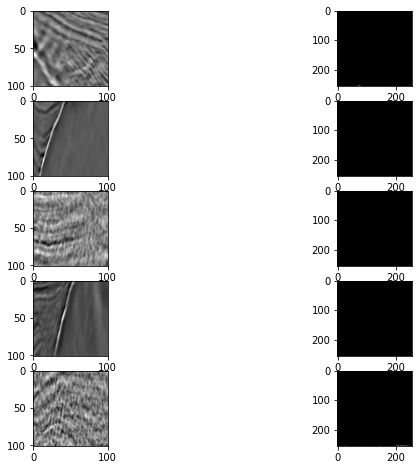

In [21]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

path = "./data/membrane/test/"
image_path_list=[path+'0.png', path+'0_predict.png',
                 path+'1.png', path+'1_predict.png',
                 path+'2.png', path+'2_predict.png',
                 path+'3.png', path+'3_predict.png',
                 path+'4.png', path+'5_predict.png',
                ]

plt.figure(figsize=(10,8))
for i,d in enumerate(image_path_list):
    plt.subplot(5,2,i+1)
    plt.imshow(mpimg.imread(d),cmap="gray")

## 【問題2】コードリーディング  
>論文[1]に目を通した上で、上記実装のコードリーディングを行ってください。

【論文の要点】  

- 利用可能な注釈付きサンプルをより効率的に使用するために、強力なデータ拡張を使用するネットワークとトレーニング戦略

- コンテキストをキャプチャするための縮小パスと、正確なローカリゼーションを可能にする対称的な拡張パスで構成

- 非常に少ない画像からエンドツーエンドでトレーニングできる高速なネットワーク

- 弾性変形によるデータ拡張のおかげで、必要な注釈付き画像はごくわずかNVidia Titan GPU（6 GB）でのトレーニング時間はわずか10時間と非常に合理的

【コードリーディング】  
- main.py  
    - データ拡張を行っている箇所  
      data_gen_args = dict(rotation_range=0.2,  
                width_shift_range=0.05,  
                height_shift_range=0.05,  
                shear_range=0.05,  
                zoom_range=0.05,  
                horizontal_flip=True,  
                fill_mode='nearest')  
                
    - u-net を用いている箇所　　
            model = unet()
            
- model.py
    - u-netの箇所（conv1〜５までのinputとup6〜conv10のoutputに分かれている）  
    
    def unet(pretrained_weights = None,input_size = (256,256,1)):
        inputs = Input(input_size)
        conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)  
        conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)  
        pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)  
        conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)  
        conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)  
        pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)  
        conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)  
        conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)  
        pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)  
        conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)  
        conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)  
        drop4 = Dropout(0.5)(conv4)  
        pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)  

        conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)  
        conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)  
        drop5 = Dropout(0.5)(conv5)  

        up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))  
        merge6 = concatenate([drop4,up6], axis = 3)  
        conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)  
        conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)  

        up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))  
        merge7 = concatenate([conv3,up7], axis = 3)  
        conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)  
        conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)  

        up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))  
        merge8 = concatenate([conv2,up8], axis = 3)  
        conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)  
        conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)  

        up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))  
        merge9 = concatenate([conv1,up9], axis = 3)  
        conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)  
        conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)  
        conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)  
        conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)  



以上